# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [1]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
# import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
# import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY


hexagons                                           geometry     lon  \
0  8755a5318ffffff  POLYGON ((24.25439 -16.63633, 24.24407 -16.645... 24.2419   
1  873980648ffffff  POLYGON ((31.57429 -8.83211, 31.56467 -8.84303... 31.5613   
2  8755ac054ffffff  POLYGON ((22.60573 -16.09723, 22.59554 -16.106... 22.5934   
3  87399e8a9ffffff  POLYGON ((29.20019 -9.25349, 29.19050 -9.26410... 29.1874   
4  875530676ffffff  POLYGON ((26.37327 -13.19218, 26.36319 -13.202... 26.3606   

       lat  
0 -16.6315  
1  -8.8282  
2 -16.0925  
3  -9.2496  
4 -13.1878

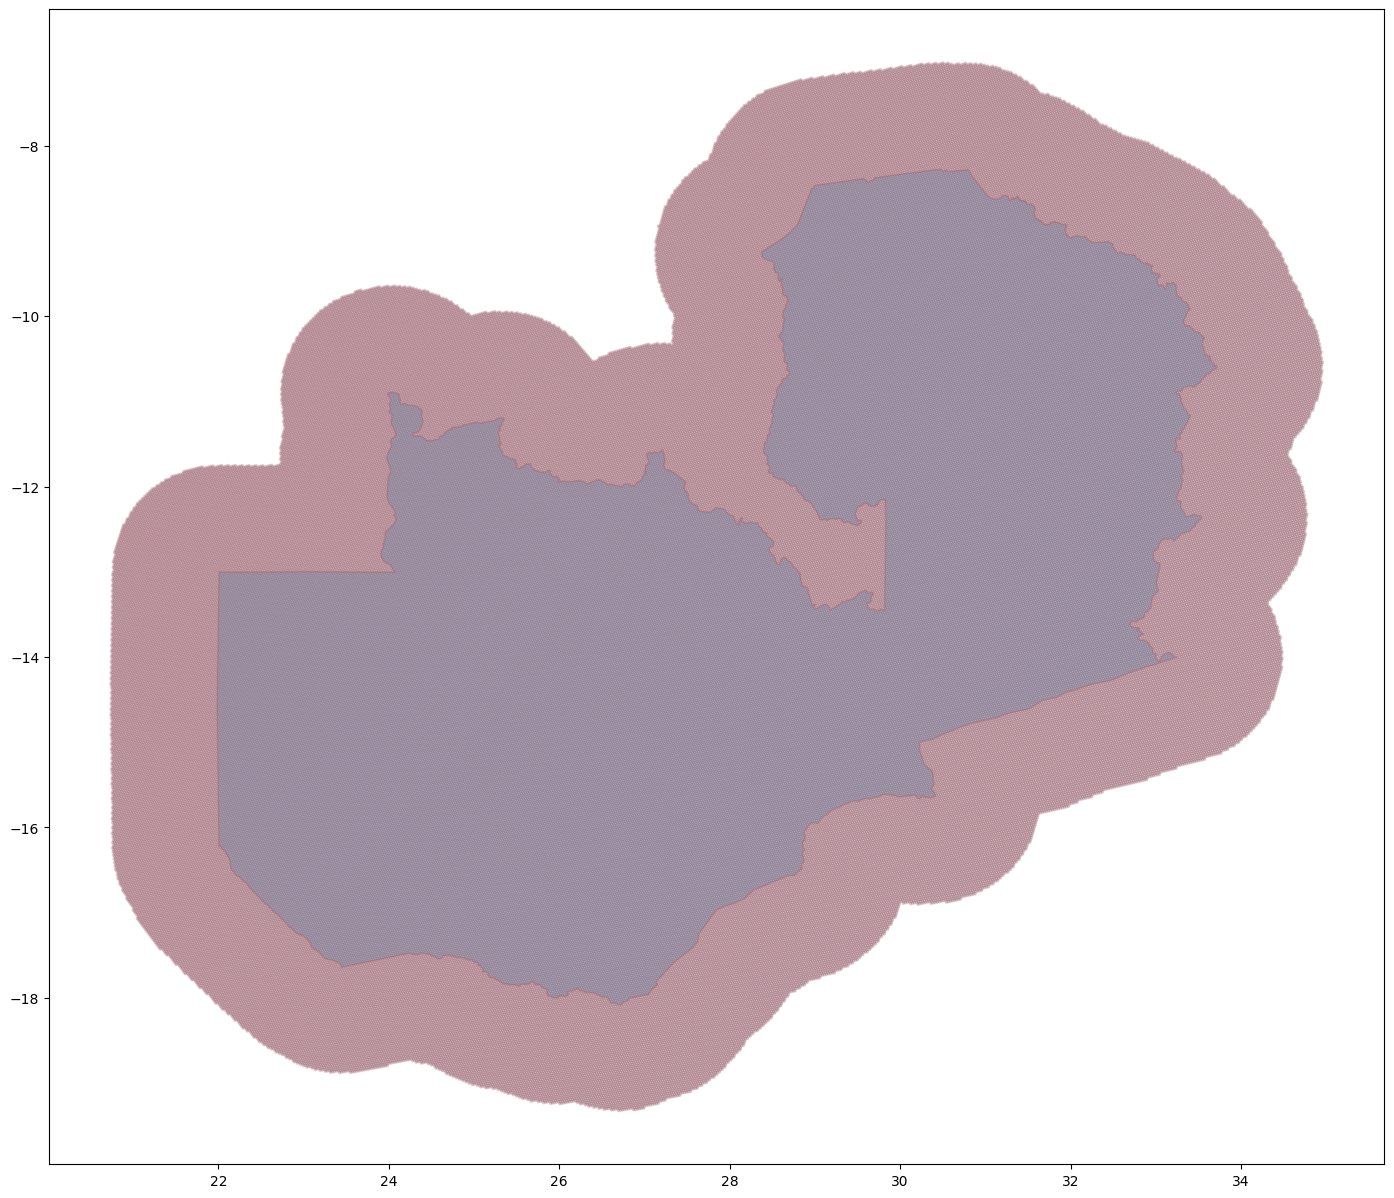

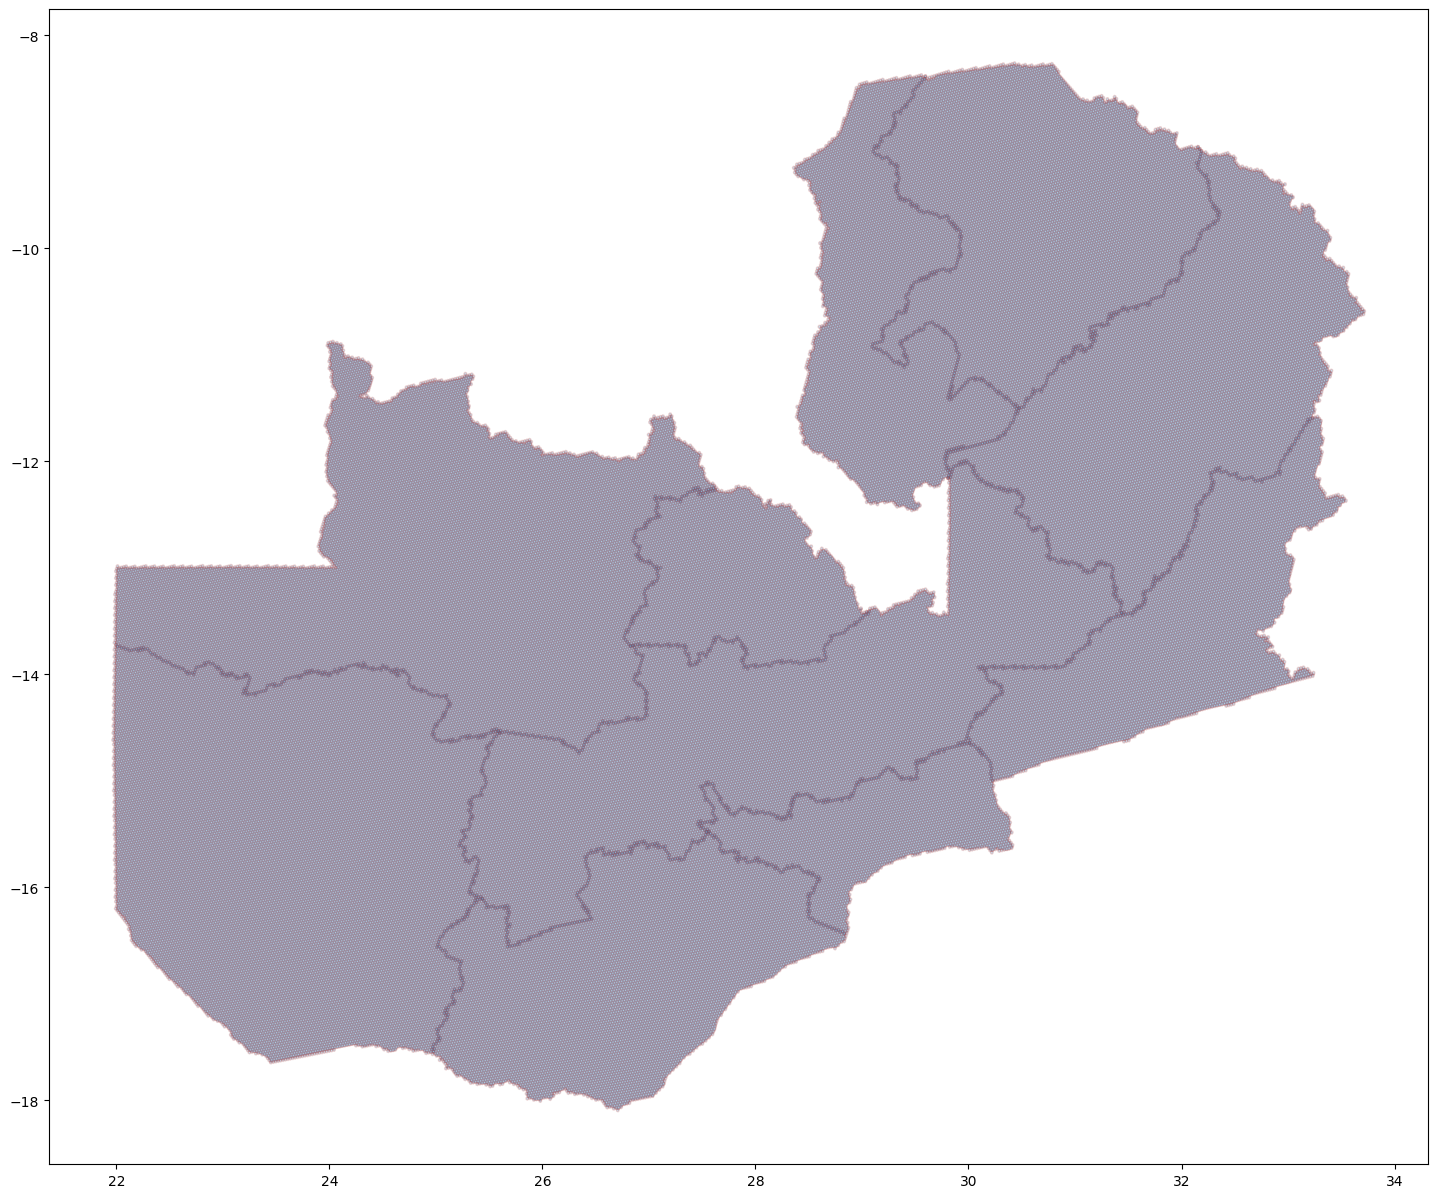

In [7]:
%run BaseGrid.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [8]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [9]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

2024-01-27 17:36:26.357128
2024-01-27 18:43:16.422576
2024-01-27 23:19:02.098419
2024-01-27 23:26:11.137996


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-01-27 23:26:58.940099
-1.2319999933242798
1.496250033378601


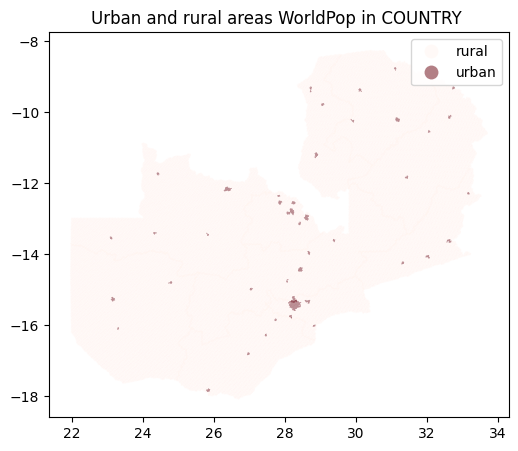

Number of res HH in urban and rural areas in: 
Copperbelt 449,077 85,356
Muchinga 24,953 151,730
North-Western 91,501 116,233
Western 54,466 205,604
Luapula 44,689 228,300
Northern 72,867 230,684
Central 98,493 292,947
Southern 120,410 316,294
Eastern 82,166 369,725
Lusaka 523,768 108,025
total Buildings in Copperbelt 1,117,170 urban: 604,165 rural: 513,005
share Build urban: 54% rural: 46%
total Buildings in Muchinga 623,493 urban: 80,335 rural: 543,158
share Build urban: 13% rural: 87%
total Buildings in North-Western 576,163 urban: 151,021 rural: 425,142
share Build urban: 26% rural: 74%
total Buildings in Western 796,764 urban: 80,858 rural: 715,906
share Build urban: 10% rural: 90%
total Buildings in Luapula 615,968 urban: 84,579 rural: 531,389
share Build urban: 14% rural: 86%
total Buildings in Northern 823,956 urban: 104,365 rural: 719,591
share Build urban: 13% rural: 87%
total Buildings in Central 1,533,577 urban: 321,668 rural: 1,211,909
share Build urban: 21% rural: 79%
tot

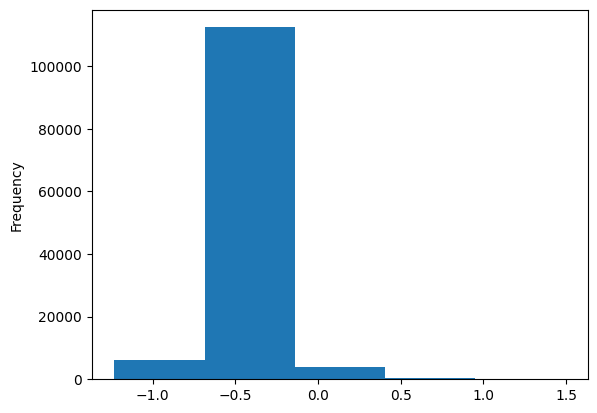

[(-1.2319999933242798, 5), (-0.6863499879837036, 73), (-0.14069998264312744, 365), (0.40495002269744873, 1250), (0.9506000280380249, 3012)]


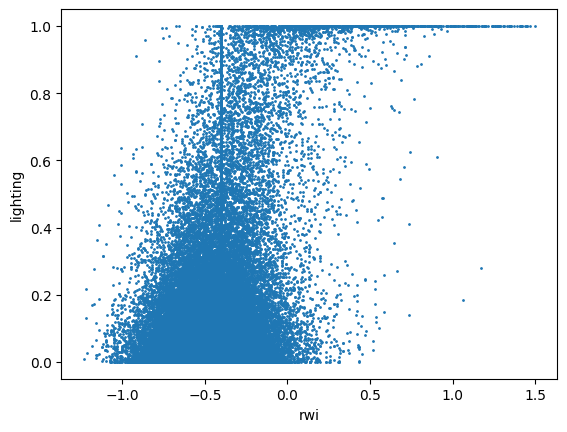

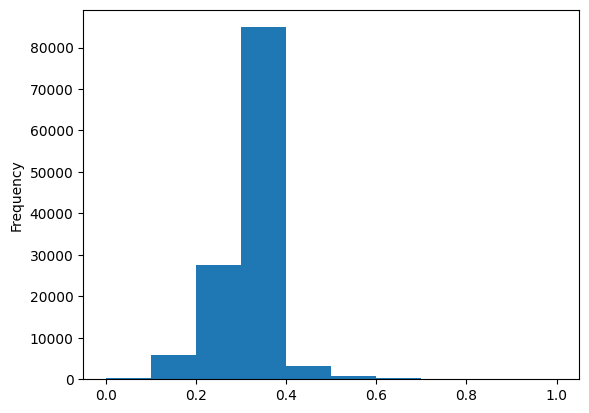

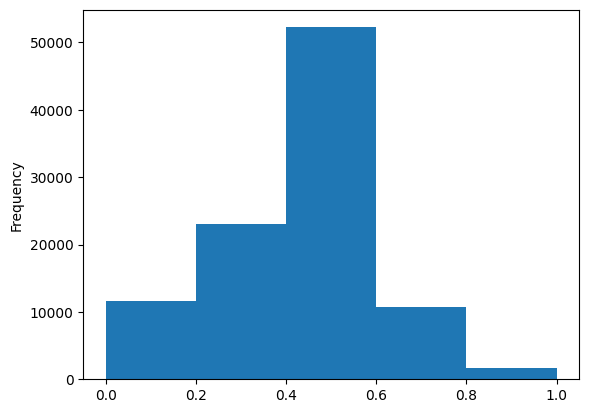

residential electricity consumption: 3,655 GWh
residential electricity consumption UN STATS: 4,022 GWh
residential electricity consumption assessed: 3,655 GWh
Residential electricity consumption assessed before scaling:
Copperbelt 1,029.1 GWh
Muchinga 50.6 GWh
North-Western 175.8 GWh
Western 96.7 GWh
Luapula 137.8 GWh
Northern 136.1 GWh
Central 254.6 GWh
Southern 247.5 GWh
Eastern 156.6 GWh
Lusaka 1,370.3 GWh
110%
Residential electricity consumption assessed after scaling:
Copperbelt 1,132.5 GWh
Muchinga 55.6 GWh
North-Western 193.5 GWh
Western 106.4 GWh
Luapula 151.6 GWh
Northern 149.8 GWh
Central 280.2 GWh
Southern 272.4 GWh
Eastern 172.3 GWh
Lusaka 1,508.0 GWh
services electricity consumption UN STATS: 722 GWh
6,555,215 services buildings
total services buildings with access: 2,515,779
287 kWh per building
residential electricity consumption: 4,022 GWh


In [10]:
%run Residential/BuildingDemandMethod1_Simplified.ipynb
total_residentialenergy_assessed = grid["REnS_kWh"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

In [11]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [1]:
%run Industry/IndustryDemand.ipynb
print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

total statistical nonFerrousMetals electricity consumption: 22,897.0 TJ or  6.4 TWh
total statistical mining electricity consumption: 818.0 TJ or  0.2 TWh
total statistical nonFerrousMetals and mining electricity consumption: 23,715.0 TJ or  6.6 TWh
total calculated energy consumption: 23,565.7 TJ or  6.5 TWh
Coverage energy in total statistical nonFerrousMetals and mining electricity consumption: 99 %
Industry electricity consumption in COUNTRY : 6.6 TWh
Industry electricity consumption in COUNTRY 6.6 TWh


In [2]:
#Concatenate results
# gridRes = gpd.read_file(out_path + "\\" + "res_energy_map.shp")
gridRes = gpd.read_file(out_path + "\\" + "ser_energy_map.shp") #contains services and residential data
# gridRes = gridRes.to_crs(crs_proj)
gridInd = gpd.read_file(out_path + "\\" + "ind_energy_map.shp")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridRes.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

hexagons     lon      lat  index_righ    NAME_1  id  buildingss  \
0  8755a5318ffffff 24.2419 -16.6315      9.0000   Western   1      9.0000   
1  873980648ffffff 31.5613  -8.8282      7.0000  Northern   2     44.0000   
2  8755ac054ffffff 22.5934 -16.0925      9.0000   Western   3         NaN   
3  87399e8a9ffffff 29.1874  -9.2496      3.0000   Luapula   4         NaN   

   locationWP   HREA     rwi  ... ResEnerg_1 ResEnerg_2 ResEnergy_  REnS_kWh  \
0      0.0000 0.0337 -0.4000  ...          5          5     0.4349    0.4319   
1      0.0000 0.0414 -0.2340  ...          5          5     2.9178    2.8973   
2         NaN 0.0000 -0.4000  ...          5          5        NaN       NaN   
3         NaN 0.0602 -0.4000  ...          5          5        NaN       NaN   

   serBui  serBUi_Acc  SEn_kWh  \
0  6.4153      0.2159  61.9282   
1 29.8946      1.2368 354.7776   
2     NaN         NaN      NaN   
3     NaN         NaN      NaN   

                                            geometry  Energy Ele  IndEne_TJ  
0  POLYGON ((24.25439 -16.63633, 24.24407 -16.645...         NaN        NaN  
1  POLYGON ((31.57429 -8.83211, 31.56467 -8.84303...         NaN        NaN  
2  POLYGON ((22.60573 -16.09723, 22.59554 -16.106...         NaN        NaN  
3  POLYGON ((29.20019 -9.25349, 29.19050 -9.26410...         NaN        NaN  

[4 rows x 37 columns]

In [3]:
#Unit
grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
total_ind = grid["IndEnergy_GWh"].sum()
print(f"{total_ind:,.0f}", "GWh")
grid['REnS_GWh'] = grid['REnS_kWh']/10**6
total_res = grid["REnS_GWh"].sum()
print(f"{total_res:,.0f}", "GWh")
grid['SEn_GWh'] = grid['SEn_kWh']/10**6
total_ser = grid["SEn_GWh"].sum()
print(f"{total_ser:,.0f}", "GWh")

6,588 GWh
4,022 GWh
722 GWh


In [4]:
grid["TotalDem"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                             row["IndEnergy_GWh"]
                                                     ])), axis=1) #sum in GWh

In [5]:
total = grid["TotalDem"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

total electricity consumption: 11,332 GWh


In [6]:
grid.head(3)

hexagons     lon      lat  index_righ    NAME_1  id  buildingss  \
0  8755a5318ffffff 24.2419 -16.6315      9.0000   Western   1      9.0000   
1  873980648ffffff 31.5613  -8.8282      7.0000  Northern   2     44.0000   
2  8755ac054ffffff 22.5934 -16.0925      9.0000   Western   3         NaN   

   locationWP   HREA     rwi  ...  serBui serBUi_Acc  SEn_kWh  \
0      0.0000 0.0337 -0.4000  ...  6.4153     0.2159  61.9282   
1      0.0000 0.0414 -0.2340  ... 29.8946     1.2368 354.7776   
2         NaN 0.0000 -0.4000  ...     NaN        NaN      NaN   

                                            geometry  Energy Ele  IndEne_TJ  \
0  POLYGON ((24.25439 -16.63633, 24.24407 -16.645...         NaN        NaN   
1  POLYGON ((31.57429 -8.83211, 31.56467 -8.84303...         NaN        NaN   
2  POLYGON ((22.60573 -16.09723, 22.59554 -16.106...         NaN        NaN   

   IndEnergy_GWh  REnS_GWh  SEn_GWh  TotalDem  
0            NaN    0.0000   0.0001    0.0001  
1            NaN    0.0000   0.0004    0.0004  
2            NaN       NaN      NaN    0.0000  

[3 rows x 41 columns]

### Export result

In [7]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [8]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

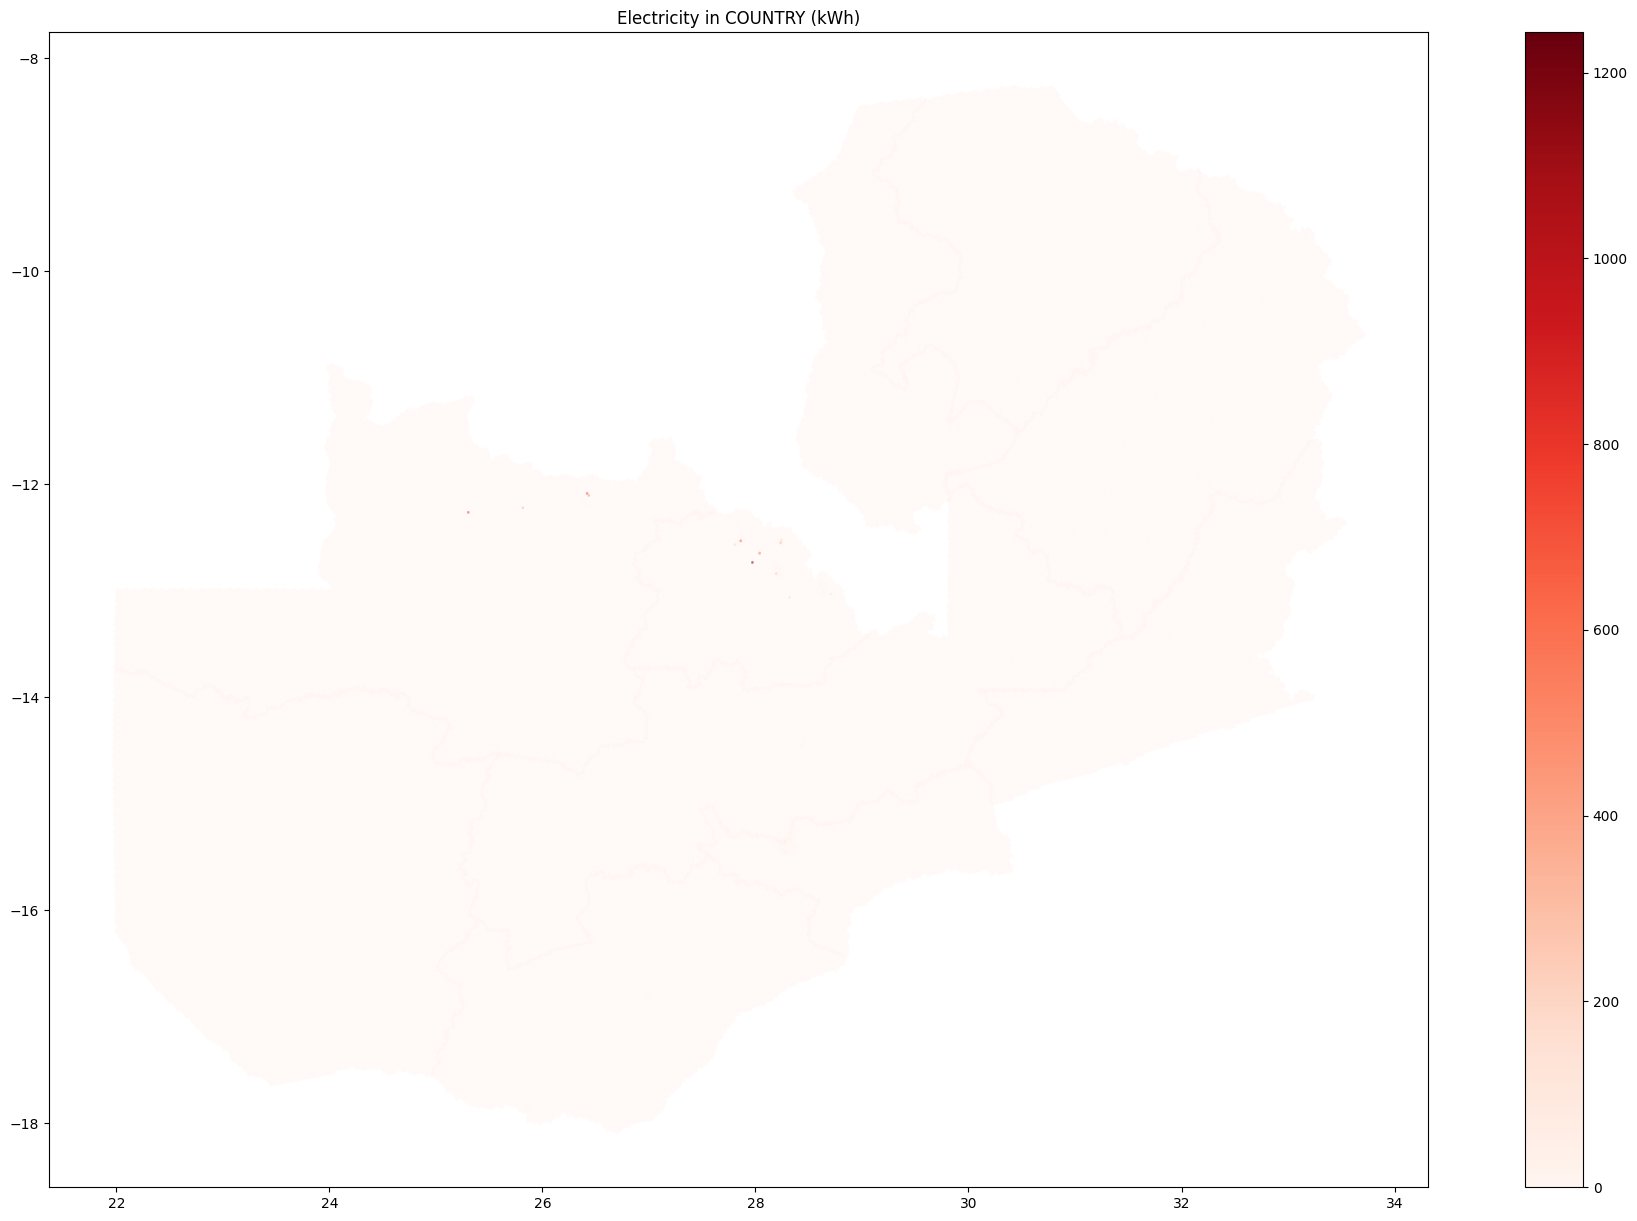

In [9]:
# Plot the demand map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')

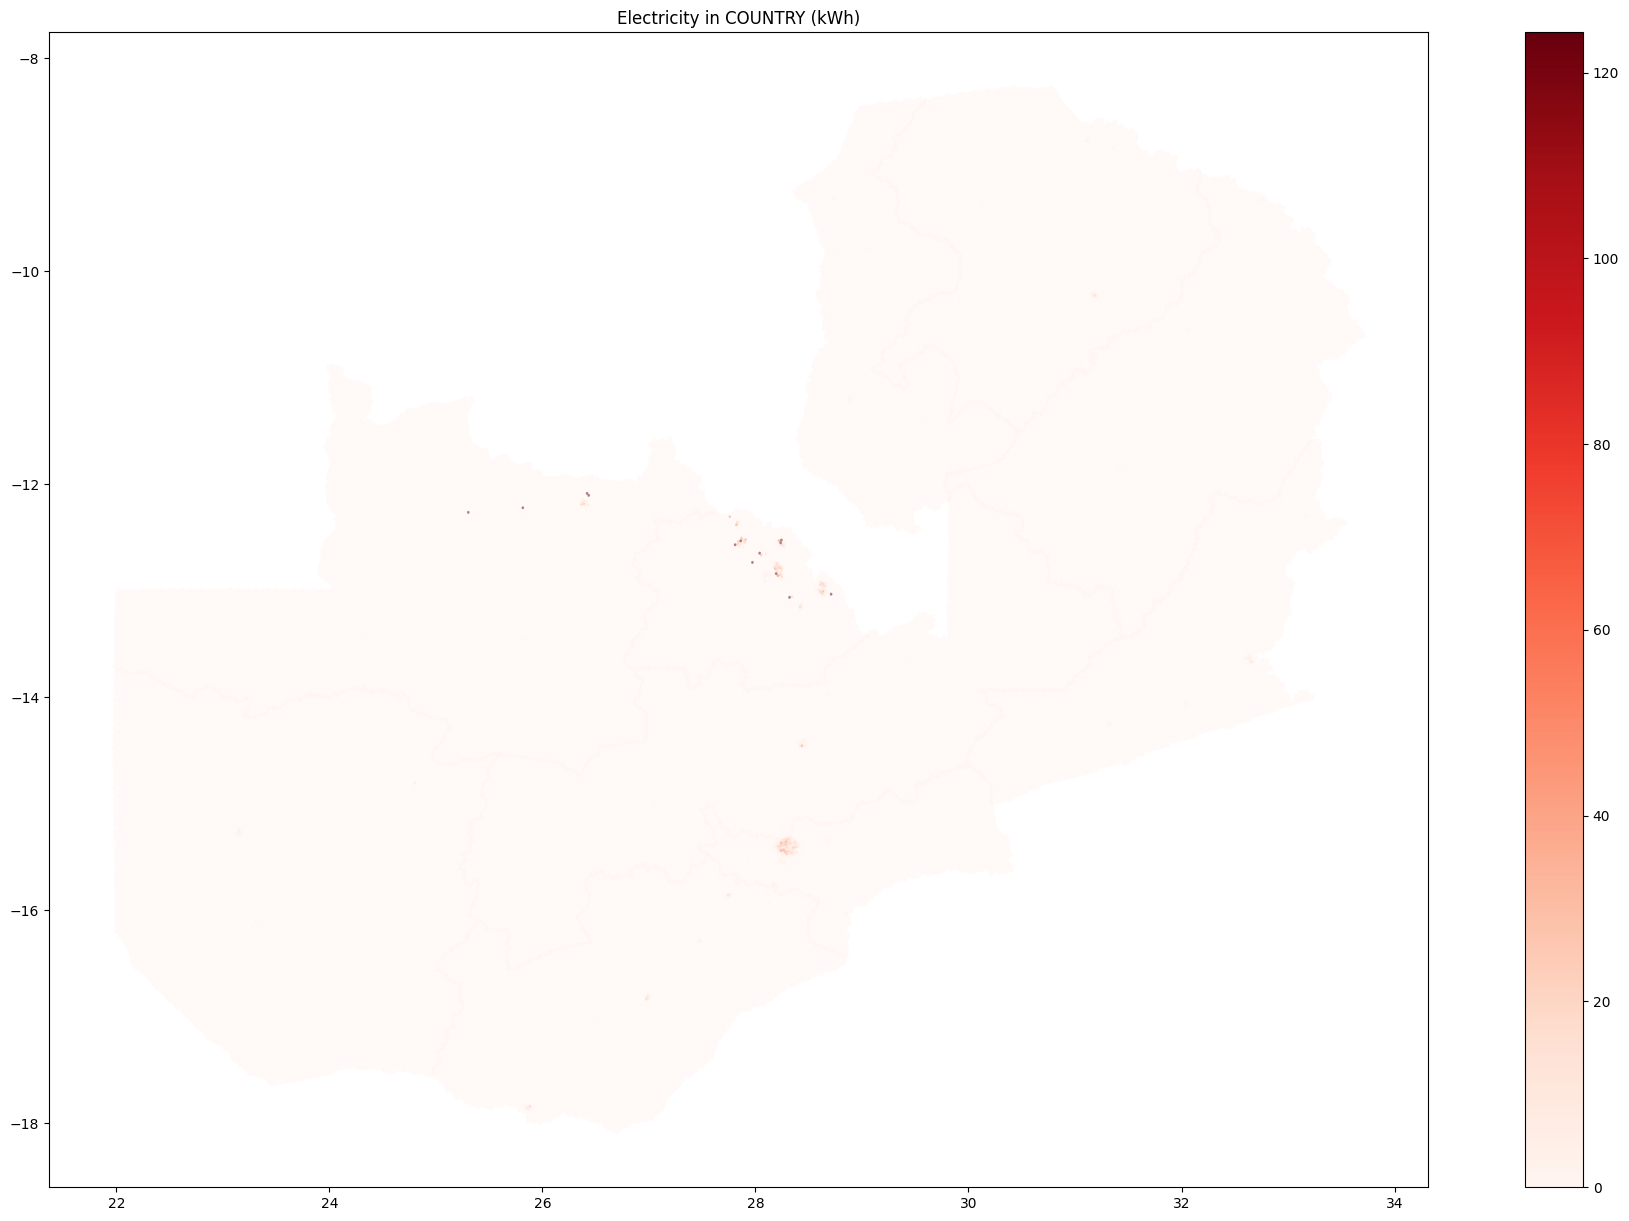

In [10]:
# Plot the demand map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Set the threshold
# threshold = np.percentile(npgrid['TotalDem'], 90)
threshold = 0.1 * grid['TotalDem'].max()

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig('sample_priority_map_threshold.png', bbox_inches='tight')

NameError: name 'colors' is not defined

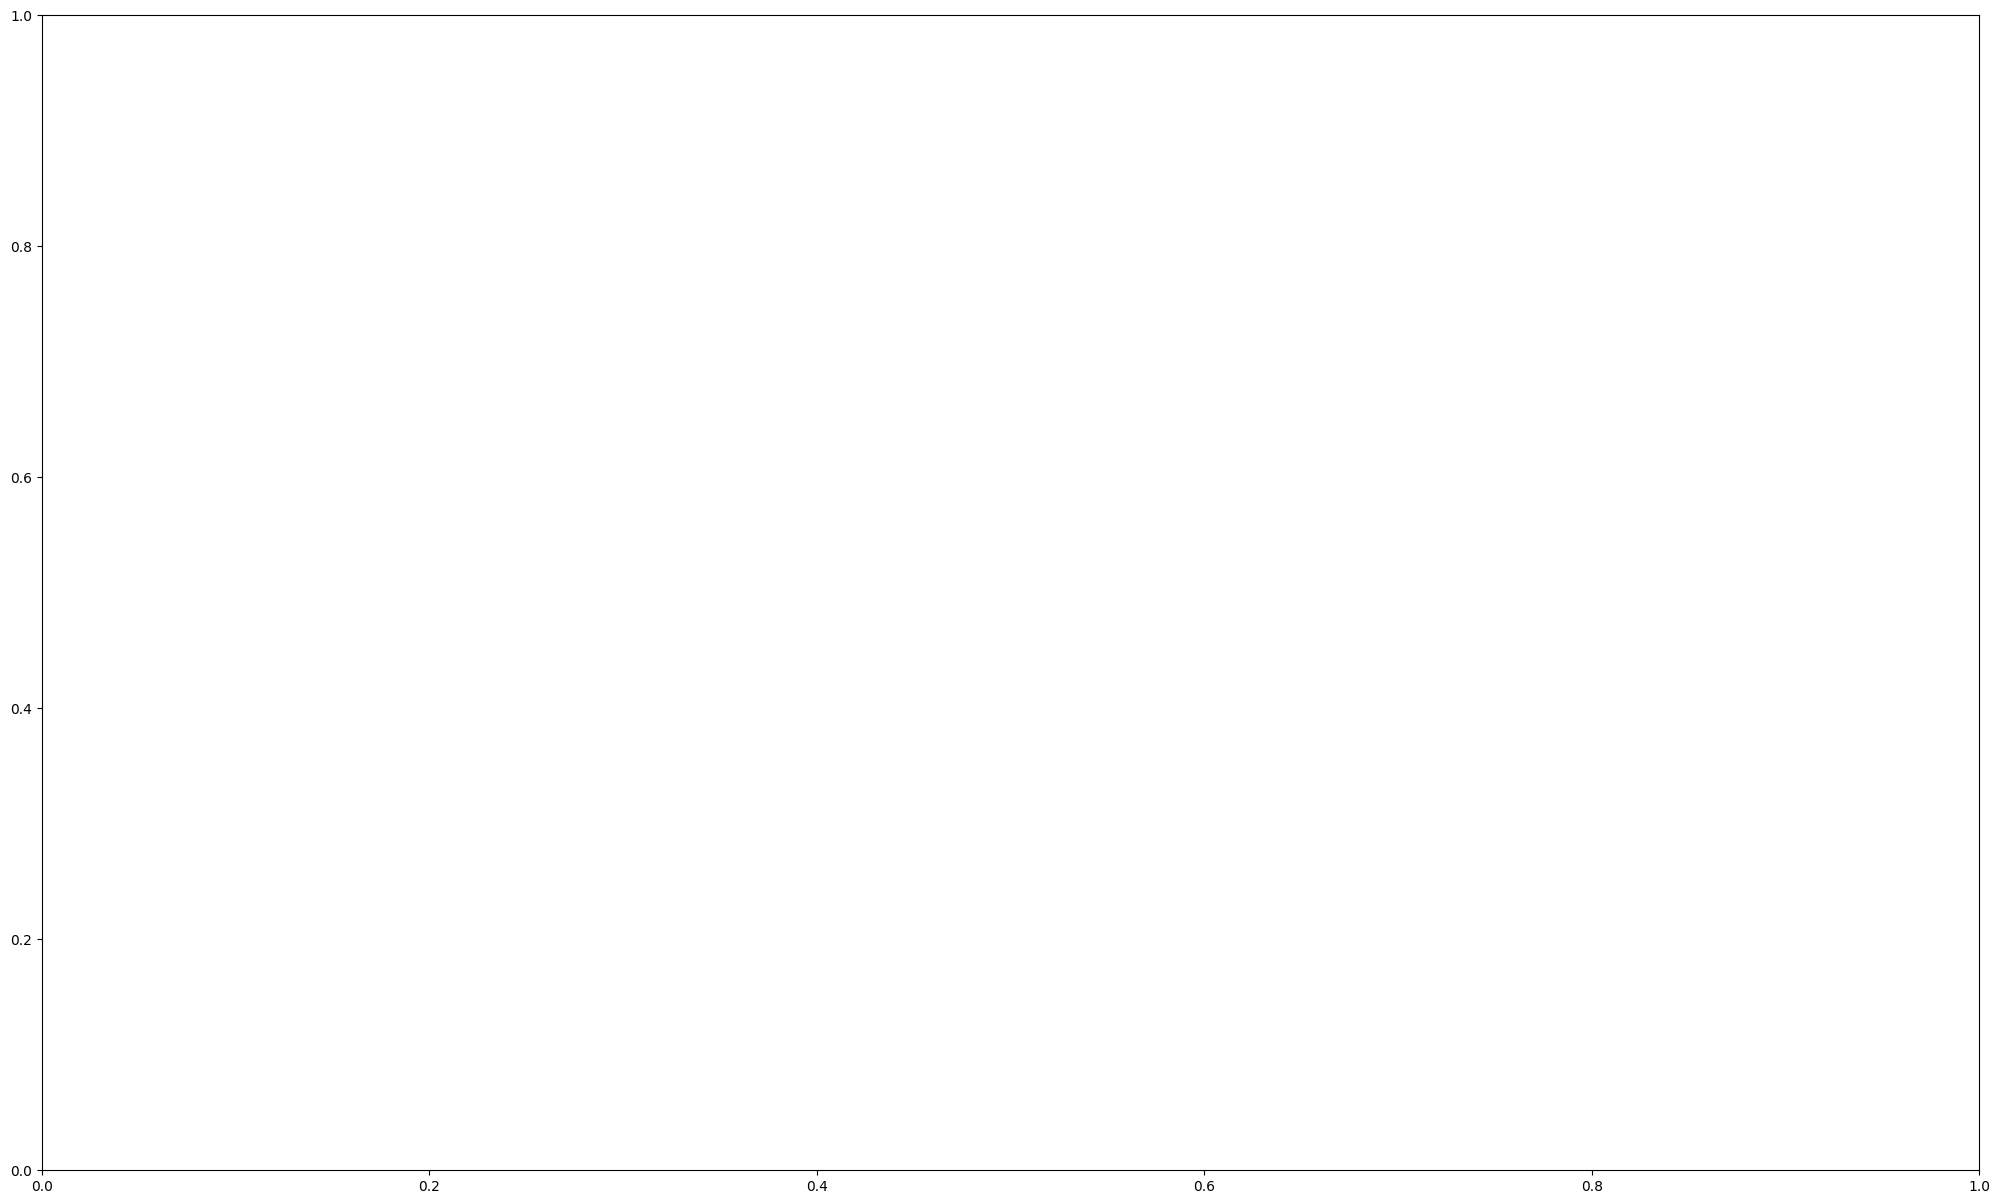

In [11]:
# Plot the demand map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['TotalDem'].max()))

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Save plot as figure 
plt.savefig('sample_priority_map_log.png', bbox_inches='tight')